Import Libraries

In [337]:
import pandas as pd
import numpy as np
import os
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns


Currency Codes

In [338]:
country_currency_codes_table = {
    'Burundi': 'BIF',
    'Benin': 'XOF',
    'Burkina Faso': 'XOF',
    'Central African Republic': 'XAF',
    "Côte d'Ivoire": 'XOF',
    'Cameroon': 'XAF',
    'Democratic Republic of the Congo': 'CDF',
    'Republic of Congo': 'XAF',
    'Comoros': 'KMF',
    'Eritrea': 'ERN',
    'Ethiopia': 'ETB',
    'Ghana': 'GHS',
    'Guinea': 'GNF',
    'The Gambia': 'GMD',
    'Guinea-Bissau': 'XOF',
    'Liberia': 'LRD',
    'Madagascar': 'MGA',
    'Mali': 'XOF',
    'Mozambique': 'MZN',
    'Mauritania': 'MRU',
    'Malawi': 'MWK',
    'Niger': 'XOF',
    'Rwanda': 'RWF',
    'Sudan': 'SDG',
    'Senegal': 'XOF',
    'Sierra Leone': 'SLL',
    'Somalia': 'SOS',
    'Sao Tomee and Principe': 'STN',
    'Chad': 'XAF',
    'Togo': 'XOF',
    'Tanzania': 'TZS',
    'Uganda': 'UGX',
    'Zambia': 'ZMW'
}


Read Data

In [339]:
#read in stata dataset as dataframe "country_code_df"
country_code_df = pd.read_stata("codesffactors_Mar23_2019.dta") 
country_code_df.replace('--', np.nan, inplace=True) #replace all entries that are '--' with NaN data value

country_code_df.head()

,countryname,wbctry,wbcode,wbregion,wbigroup2017,wblcat2017,hipc,emu,cemac,waemu,imfcode,imfweocode,imfweoiso,imfweoctry,region
0,Aruba,Aruba,ABW,Latin America & Caribbean,High income,NaN,0,0,0,0,NaN,314.0,ABW,Aruba,LAC
1,Afghanistan,Afghanistan,AFG,South Asia,Low income,IDA,1,0,0,0,512.0,512.0,AFG,Afghanistan,SAS
2,Angola,Angola,AGO,Sub-Saharan Africa,Lower middle income,IBRD,0,0,0,0,614.0,614.0,AGO,Angola,SSA
3,Anguilla,NaN,AIA,Latin America & Caribbean,NaN,NaN,0,0,0,0,312.0,NaN,NaN,NaN,LAC
4,Albania,Albania,ALB,Europe & Central Asia,Upper middle income,IBRD,0,0,0,0,914.0,914.0,ALB,Albania,ECA


In [340]:
region_classification_ls = country_code_df['wbregion'].unique() #get a list of region classifications
income_classification_ls = country_code_df['wbigroup2017'].unique() #get a list of income classifications
income_classification_ls = [x for x in income_classification_ls if not pd.isna(x)] # remove '--' from income_classification_ls

print(f"The region classifications are: {', '.join(country for country in region_classification_ls)}")
print(f"The income classifications are: {', '.join(country for country in income_classification_ls)}")

The region classifications are: Latin America & Caribbean, South Asia, Sub-Saharan Africa, Europe & Central Asia, Middle East & North Africa, East Asia & Pacific, North America
The income classifications are: High income, Low income, Lower middle income, Upper middle income


In [341]:
ssa_hipc_countries = country_code_df[(country_code_df['hipc'] == 1) & (country_code_df['wbregion'] == 'Sub-Saharan Africa')]
ssa_hipc_countries_ls = ssa_hipc_countries['imfweoctry'].to_list()

len(ssa_hipc_countries_ls)

33

Read in IMF's Government Finance Statistics

In [342]:
master_table = {}
folder_path = "expenditure-investment-gdp-data"

# Loop that goes through all files 'file_name' in the folder 'folder_path'
for file_name in os.listdir(folder_path):
  if file_name.endswith('.xlsx') and not file_name.startswith('~$'): #check to see if is spreadsheet .xlsx format
    raw_df = pd.read_excel(folder_path+ "/" + file_name) #read in .xlsx as dataframe
    master_table[file_name[:-5]] = raw_df #store dataframe as an entry in the master_table hash table

# master_table["Central African Republic"]
for key in master_table:
  print(master_table[key])

                                           Unnamed: 0   Unnamed: 1  \
0   Statement of Operations (Revenue, Expenditures...          NaN   
1                                      Country: Benin          NaN   
2                Sector: Budgetary central government          NaN   
3                                Unit: Percent of GDP          NaN   
4                                        Scale: Units          NaN   
5                                                 NaN          NaN   
6                                                 NaN  2010.000000   
7                    TRANSACTIONS AFFECTING NET WORTH          NaN   
8                                             Revenue    18.782603   
9                                               Taxes    15.534492   
10                               Social contributions     0.474120   
11                                             Grants     1.515431   
12                                      Other revenue     1.258560   
13                  

Filtering

In [343]:
#REMOVE "JUNK" ROWS AND CONVERT TO CORRECT SCALE (MILLION/BILLIONS)
for key in master_table: #loop through table (where key is the country name) (master_table[key] is the dataframe stored in the master_table indexed by key)
  scale = master_table[key].iloc[4,0] #get if values have scale of billions or millions
  
  # Drop rows 0 to 5, reformatting indexes and column headers
  master_table[key] = master_table[key].drop([0, 1, 2, 3, 4, 5]) 
  # master_table[key] = master_table[key].drop([11]) 


  master_table[key] = master_table[key].reset_index(drop=True) 
  master_table[key].columns = master_table[key].iloc[0]
  master_table[key] = master_table[key][1:]
  # master_table[key].rename(index={11: "Grants received"}, inplace=True)

  master_table[key] = master_table[key].set_index(master_table[key].columns[0])
  master_table[key].columns = [int(float(col)) for col in master_table[key].columns]
  # grants_indices = master_table[key].index[master_table[key].index == 'Grants']
  # if len(grants_indices) > 0:
  #     first_grants_index = grants_indices[0]
  #     master_table[key].rename(index={first_grants_index: 'Grants Received'}, inplace=True)

  index_list = list(master_table[key].index)

  # Find the first occurrence of 'Grants' and rename it
  for i in range(len(index_list)):
      if index_list[i] == 'Grants':
          index_list[i] = 'Grants received'
          break

  # Assign the modified index back to the dataframe
  master_table[key].index = index_list


  # master_table[key] = master_table[key].rename({4: 'Tax Grants'}, axis='index')
  # index_to_rename = master_table[key].index[master_table[key]['name'] == 'grants'][0]
  # master_table[key].at[index_to_rename, 'name'] = 'tax grants'


  # master_table[key] = master_table[key].fillna(0)

  # if scale == "Scale: Billions":
  #   master_table[key] = master_table[key]* (10 ** 9) #multiple every value in dataframe by 1e9 if scale is billion
  # elif scale == "Scale: Millions":
  #   master_table[key] = master_table[key]* (10 ** 6) #multiple every value in dataframe by 1e9 if scale is billion


#FILTER OUT YEAR COLUMNS ACCOUNTING DOESNT ADD UP
# first level: make sure 'Taxes', 'Social Contributions', 'Grants, 'Other Revenue' Sums to 'Revenue'
# second level: make sure 'Taxes on income, profits, & capital gains', 'Taxes on payroll & workforce', 'Taxes on property', 'Taxes on goods & services', 'Taxes on int trade & transactions', 'Other taxes n.e.c.' sum to 'Taxes'

first_level_ls = ['Compensation of employees', 'Use of goods and services', 'Consumption of fixed capital', 'Interest', 'Subsidies', 'Grants', 'Social benefits', 'Other expense', 'Net/gross investment in nonfinancial assets']
# second_level_ls = ['Taxes on income, profits, & capital gains', 'Taxes on payroll & workforce', 'Taxes on property', 'Taxes on goods & services', 'Taxes on int trade & transactions', 'Other taxes n.e.c.']
                  
for key in master_table:
  years_accounting_error_ls = []
  years_available = master_table[key].columns
  for year in years_available:
    country_year_df = master_table[key][year]
    # revenue = 0 
    exp = 0
    for category in first_level_ls:
      if category in country_year_df.index:
        exp += country_year_df[category]
      # else: 
      #   print(category)
    # for category in second_level_ls:
    #   if category in country_year_df.index:
    #     taxes += country_year_df[category]
    # if round(taxes, 0) != round(country_year_df['Taxes'], 0) or round(revenue, 0) != round(country_year_df['Revenue'], 0):
    
    margin = 0.001
    lower_bound_exp = country_year_df['Expenditure'] - country_year_df['Expenditure']*margin
    upper_bound_exp = country_year_df['Expenditure'] + country_year_df['Expenditure']*margin

    # print(lower_bound_exp)
    # print(upper_bound_exp)
    # print(exp)
    if exp < lower_bound_exp or exp > upper_bound_exp:
    
      print(f"{round(exp, 0)}, {round(country_year_df['exp'], 0)}")

      years_accounting_error_ls.append(year)
  
  print(key)
  print(years_accounting_error_ls)
  master_table[key].drop(columns=years_accounting_error_ls, inplace=True)
 
    
    

#FILTER OUT COUNTRIES WITH LESS THAN 7 YEARS OF DATA
less_than_seven_years_data_countries = [] #create list to store countries with less than 7 years of historial data
for key in master_table: #iterate through master_table
  num_columns = master_table[key].shape[1] #count the number of columns (each column represents a year)
  if num_columns < 7: #if less than 7 columns/year, add to list to delete
    less_than_seven_years_data_countries.append(key)

print('remove')
for country in less_than_seven_years_data_countries:
  print(country)
  del master_table[country] #delete countries with less than 7 years from data table

master_table["Zambia"]

Benin
[]
Senegal
[]
Côte d'Ivoire
[]
Burkina Faso
[]
Central African Republic
[]
Ghana
[]
Somalia
[]
Tanzania
[]
Zambia
[]
Democratic Republic of the Congo
[]
Rwanda
[]
Republic of Congo
[]
Sudan
[]
The Gambia
[]
Togo
[]
Mali
[]
Malawi
[]
Sao Tomee and Principe
[]
Mozambique
[]
Sierra Leone
[]
Guinea-Bissau
[]
Ethiopia
[]
Burundi
[]
Liberia
[]
Cameroon
[]
Madagascar
[]
Uganda
[]
remove
Benin
Somalia
The Gambia
Guinea-Bissau
Liberia


,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
TRANSACTIONS AFFECTING NET WORTH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Revenue,16.586785,21.058592,18.310983,17.699409,18.724955,19.859871,19.822529,19.780306,20.420066,20.742244
Taxes,12.834842,14.715943,14.892364,14.347130,15.761077,14.393958,13.353177,15.184871,16.587065,16.677623
Social contributions,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Grants received,2.224197,3.590215,1.642894,1.463176,0.987268,1.564107,1.690099,2.929078,1.009103,1.146139
Other revenue,1.527745,2.752434,1.775725,1.889103,1.976610,3.901806,4.779253,1.666357,2.823897,2.918482
Expense,14.668856,14.495677,16.532242,17.853331,20.256300,23.233779,22.408675,20.922095,20.110712,21.956163
Compensation of employees,6.577420,6.095064,8.123851,7.517437,9.198772,8.941714,8.627226,8.133147,7.620317,7.433267
Use of goods and services,3.539223,5.706804,4.109597,5.129683,4.395278,4.884168,6.598705,5.051876,3.200786,3.086568
Consumption of fixed capital,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [344]:
master_table["Zambia"]

,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
TRANSACTIONS AFFECTING NET WORTH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Revenue,16.586785,21.058592,18.310983,17.699409,18.724955,19.859871,19.822529,19.780306,20.420066,20.742244
Taxes,12.834842,14.715943,14.892364,14.347130,15.761077,14.393958,13.353177,15.184871,16.587065,16.677623
Social contributions,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Grants received,2.224197,3.590215,1.642894,1.463176,0.987268,1.564107,1.690099,2.929078,1.009103,1.146139
Other revenue,1.527745,2.752434,1.775725,1.889103,1.976610,3.901806,4.779253,1.666357,2.823897,2.918482
Expense,14.668856,14.495677,16.532242,17.853331,20.256300,23.233779,22.408675,20.922095,20.110712,21.956163
Compensation of employees,6.577420,6.095064,8.123851,7.517437,9.198772,8.941714,8.627226,8.133147,7.620317,7.433267
Use of goods and services,3.539223,5.706804,4.109597,5.129683,4.395278,4.884168,6.598705,5.051876,3.200786,3.086568
Consumption of fixed capital,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Convert Currency

In [345]:
# print('keep')
# for key in master_table:
#   print(key)

# #CONVERT LOCAL CURRENCY DENOMINATED VALUES TO USD
# error_countries = []
# for key in master_table:
#   #get annual 2010-2019 USD to domestic currency exchange rate using yfinance library
#   currency = country_currency_codes_table[key] #retrieve currency symbol from 'country_currency_codes_table'
#   symbol = f"{currency}=X"
#   try:
#     data = yf.download(symbol, start="2010-01-01", end="2020-01-01", interval="1mo") #download monthly USD-Currency dataset from 2010-2020
#     yearly_data_df = data['Close'].resample('YE').mean() #get the annual average exchange rate outputted as datafram
#     yearly_data_table = yearly_data_df.to_dict() # Convert the yearly_data to a hash table with the date as the key
#     year_to_exchange_rate_dict = {key.year: value for key, value in yearly_data_table.items()} # Convert the keys to only the year part
#     print(year_to_exchange_rate_dict)

#     #convert DataFrame values to USD
#     for year in master_table[key].columns: #loop through columns in dataframe
#       year_int = int(year)  # Convert year to integer to match the dictionary keys
#       master_table[key][year] = master_table[key][year] / year_to_exchange_rate_dict[year_int] #divide each column's values by that year's exchange rate

#   except Exception as e: #if errored out
#     print(f"Could not fetch rate for {key} ({currency}): {e}")
#     error_countries.append(key) #add country to error list
#     pass
    
# for country in error_countries:
#   del master_table[country] #delete countries where currency conversion failed
 
# for key in master_table:
#   print(key)
#   print(master_table[key])

Calculate Percentages

In [346]:
# yearly_averages_percentage_ls = []

# year = 2010
# for year_average_df in yearly_averages_ls:


#   total_taxes = year_average_df['Expenditure']
#   year_average_percentage_df = year_average_df / total_taxes * 100 #take all values as a fraction of total expenditure, then convert decimal to percent, then round to two decimal places
  
#   first_level = 0
#   print(year)
#   for category in first_level_ls:
#     first_level += year_average_percentage_df[category]
#   print(first_level)
#   year += 1
  
#   yearly_averages_percentage_ls.append(year_average_percentage_df)

# for i in range(len(yearly_averages_percentage_ls)):
#   print(f"YEAR: {2010+i}")
#   print(yearly_averages_percentage_ls[i])


# for key in master_table: #iterate through master_table
#   total_taxes = master_table[key].loc['Expenditure']
#   master_table[key] = master_table[key] / total_taxes * 100 #take all values as a fraction of total expenditure, then convert decimal to percent, then round to two decimal places

master_table['Central African Republic']

,2010,2011,2012,2014,2015,2016,2017,2018,2019
TRANSACTIONS AFFECTING NET WORTH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Revenue,15.078780,10.914864,15.717551,19.105810,9.207579,15.522592,13.825754,16.416897,17.929120
Taxes,8.407895,7.540404,8.172377,4.098503,5.448991,6.807586,7.081244,8.423424,8.110260
Social contributions,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Grants received,5.871356,2.289575,6.163477,14.524525,3.544419,8.222365,6.627560,7.819778,9.357088
Other revenue,0.627392,0.911895,1.210273,0.482782,0.214169,0.492641,0.116950,0.173695,0.461772
Expense,16.336671,13.464091,8.184472,8.271978,9.306557,9.021342,8.676799,9.869788,9.690573
Compensation of employees,4.038153,4.003057,3.996115,5.748749,5.652907,4.547504,4.155406,4.847437,4.873191
Use of goods and services,9.459845,6.565684,1.950226,0.678511,1.519425,2.031592,2.305613,2.408703,2.724633
Consumption of fixed capital,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [347]:
for key in master_table:
  print(key)

Senegal
Côte d'Ivoire
Burkina Faso
Central African Republic
Ghana
Tanzania
Zambia
Democratic Republic of the Congo
Rwanda
Republic of Congo
Sudan
Togo
Mali
Malawi
Sao Tomee and Principe
Mozambique
Sierra Leone
Ethiopia
Burundi
Cameroon
Madagascar
Uganda


Calculate Yearly Averages

In [348]:
data_by_year_table = {
  2010: [],
  2011: [],
  2012: [],
  2013: [],
  2014: [],
  2015: [],
  2016: [],
  2017: [],
  2018: [],
  2019: [],
} #make table that stores data by year

# master_averages_ls = [] #make master averages list as place to store averages

for key in master_table:
  years_available = master_table[key].columns
  for year in data_by_year_table:
    if year in years_available:
      data_by_year_table[year].append(master_table[key][year])

yearly_averages_ls = [] #make a list of the yearly averages
for year in data_by_year_table:
  merged_year_df = pd.concat(data_by_year_table[year], axis=1, join='outer')
  #SUM OR MEAN?
  year_average_df = merged_year_df.mean(axis=1) #get the average of all the countries' averages
  yearly_averages_ls.append(year_average_df)

 
# #Get average over decade
# #loop through table (where key is the country name) (master_table[key] is the dataframe stored in the master_table indexed by key)
# for key in master_table:
#   per_category_average = master_table[key].mean(axis=1) #get the average of each category (ignoring np.NaN values) into a list
#   # per_category_average.drop('To other government units', inplace=True) #drop 'To other government units' since there's two rows named that and will error
#   master_averages_ls.append(per_category_average) #add each country average to to the master averages list



# merged_averages_df = pd.concat(master_averages_ls, axis=1, join='outer')
# average__of_averages_df = merged_averages_df.mean(axis=1) #get the average of all the countries' averages
# average__of_averages_df

for i in range(len(yearly_averages_ls)):
  print(f"YEAR: {2010+i}")
  print(yearly_averages_ls[i])

YEAR: 2010
TRANSACTIONS AFFECTING NET WORTH                                      NaN
Revenue                                                         20.912119
Taxes                                                           10.798495
Social contributions                                             0.058775
Grants received                                                  6.988026
Other revenue                                                    3.064237
Expense                                                         13.683970
Compensation of employees                                        4.761732
Use of goods and services                                        3.492830
Consumption of fixed capital                                          NaN
Interest                                                         0.877543
Subsidies                                                        0.783786
Grants                                                           2.824405
Social benefits            

Calculate Average Across Period

In [349]:
merged_percentages_df = pd.concat(yearly_averages_ls, axis=1, join='outer')
average_df = merged_percentages_df.mean(axis=1)
rounded_average_df = average_df.apply(lambda x: round(x, 2))

rounded_average_df = rounded_average_df.to_frame()
rounded_average_df

,0
TRANSACTIONS AFFECTING NET WORTH,NaN
Revenue,18.19
Taxes,11.98
Social contributions,0.06
Grants received,3.64
Other revenue,2.51
Expense,14.15
Compensation of employees,5.13
Use of goods and services,3.12
Consumption of fixed capital,0.00


In [350]:
#check
first_level = 0
for category in first_level_ls:
  first_level += average_df[category]
print(first_level)

# second_level = 0
# for category in second_level_ls:
#   second_level += average_df[category]
# print(second_level)

20.352612471116352


In [351]:
rounded_by_year_average_df = merged_percentages_df.round(2)
rounded_by_year_average_df

,0,1,2,3,4,5,6,7,8,9
TRANSACTIONS AFFECTING NET WORTH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Revenue,20.91,19.80,17.86,18.60,18.09,17.26,17.03,17.26,17.30,17.82
Taxes,10.80,11.25,11.40,11.67,11.83,12.26,12.44,12.66,12.45,13.04
Social contributions,0.06,0.07,0.05,0.06,0.06,0.06,0.05,0.06,0.09,0.05
Grants received,6.99,5.37,3.60,3.79,3.65,2.95,2.79,2.71,2.27,2.29
Other revenue,3.06,3.11,2.81,3.04,2.56,2.00,1.75,1.83,2.48,2.44
Expense,13.68,13.84,13.68,13.11,13.56,14.48,14.51,14.91,14.85,14.85
Compensation of employees,4.76,4.88,5.13,4.76,4.88,5.23,5.47,5.41,5.33,5.48
Use of goods and services,3.49,3.66,3.10,2.90,2.99,3.10,3.07,3.08,2.98,2.82
Consumption of fixed capital,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00


Plot Over Time

In [352]:
rounded_by_year_average_df.columns = [str(int(col) + 2010) for col in rounded_by_year_average_df.columns]

def graph(rows_to_plot):
    # sns.set(style="whitegrid")

    # Plotting
    plt.figure(figsize=(10, 6))
    for row in rows_to_plot:
        sns.lineplot(x=rounded_by_year_average_df.columns, y=rounded_by_year_average_df.loc[row], marker='o', label=row)

    # Add labels and title
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Percentage of GDP', fontsize=12)
    # plt.title('Percentage of Tax Revenue Over Time')

    # Customize the legend
    plt.legend(title='Category', title_fontsize='12', fontsize='10', loc='upper right')

    # Customize the ticks and grid
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, linestyle='--', linewidth=0.5)

    # Adjust y-axis limits to be 120% of the original range
    y_min, y_max = plt.ylim()
    y_range = y_max - y_min
    plt.ylim(y_min, y_max + 0.25 * y_range)

    # Show the plot
    plt.tight_layout()
    plt.show()

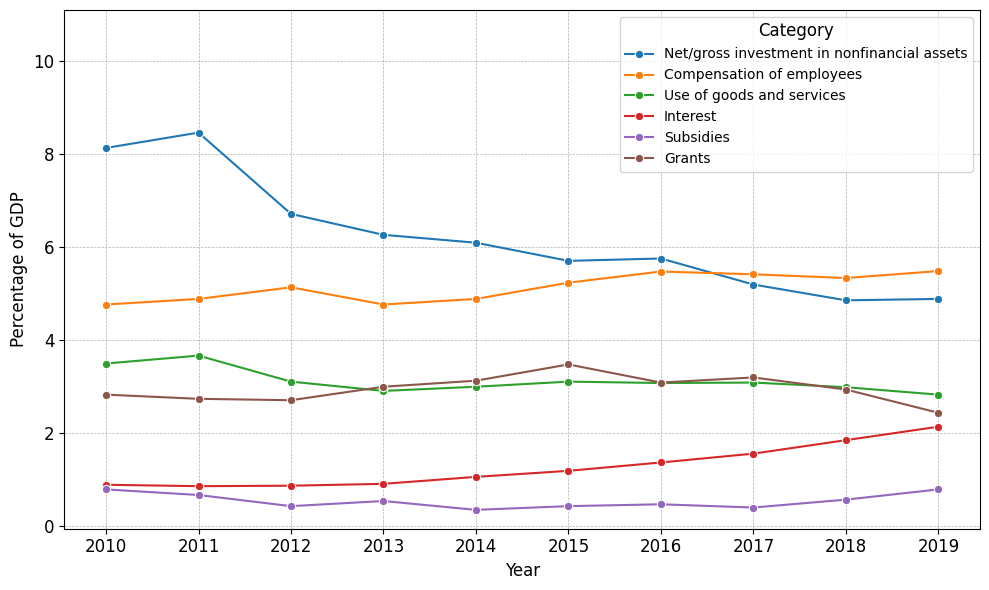

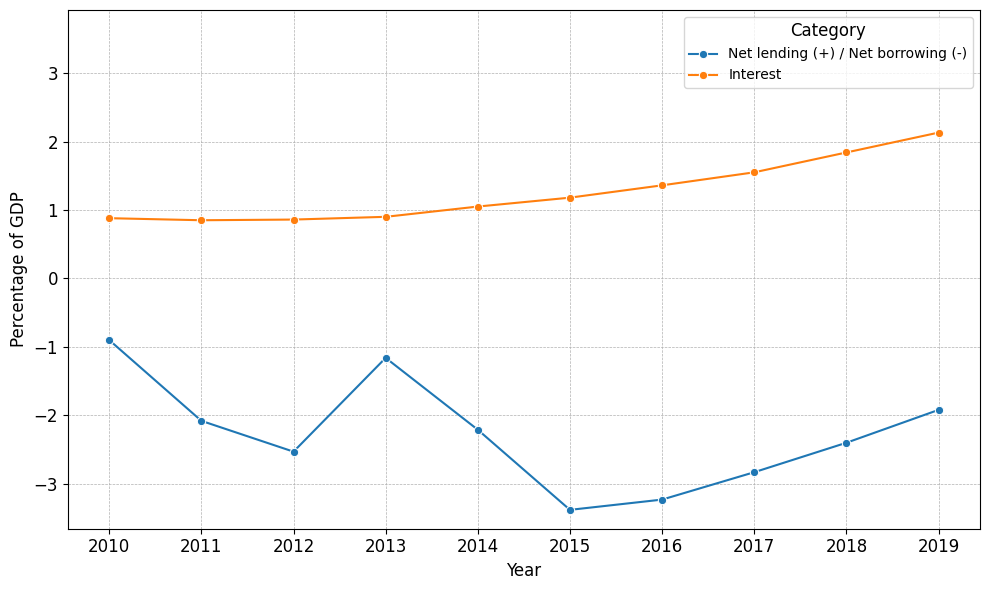

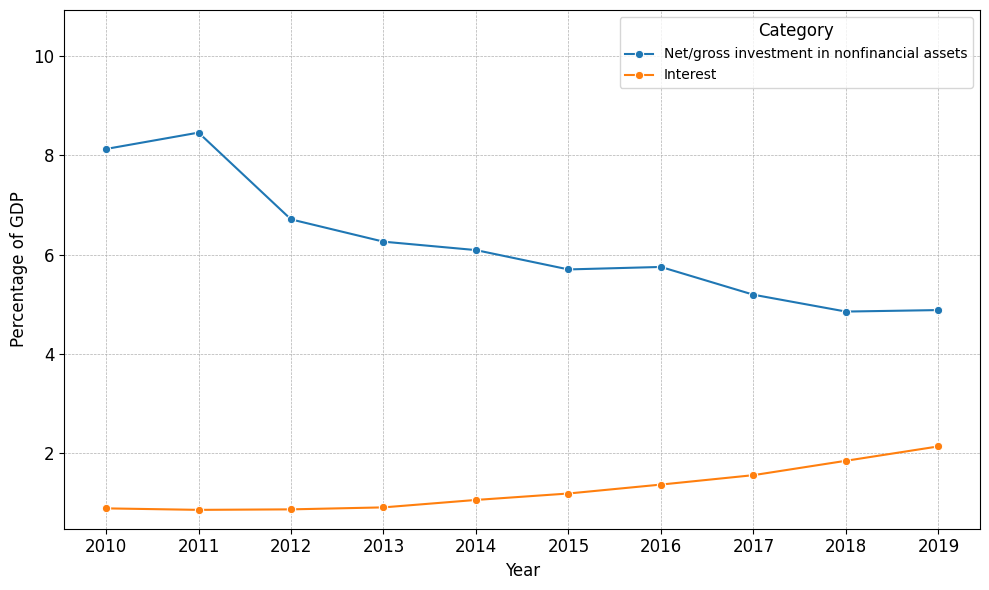

In [353]:
graph(['Net/gross investment in nonfinancial assets', 'Compensation of employees', 'Use of goods and services', 'Interest', 'Subsidies', 'Grants'])
graph(['Net lending (+) / Net borrowing (-)', 'Interest'])
graph(['Net/gross investment in nonfinancial assets', 'Interest'])

In [354]:
net_lending = rounded_by_year_average_df.loc['Net lending (+) / Net borrowing (-)']
net_borrowing = -1 * net_lending
rounded_by_year_average_df.loc['Net Borrowing'] = net_borrowing

current_spending = rounded_by_year_average_df.loc["Expense"]
interest = rounded_by_year_average_df.loc["Interest"]
current_minus_interest = current_spending - interest
rounded_by_year_average_df.loc['Current Spending minus Interest'] = current_minus_interest


social = rounded_by_year_average_df.loc['Social contributions']
other = rounded_by_year_average_df.loc['Other revenue']
other_rev_minus_grants = social + other
rounded_by_year_average_df.loc['Other Revenue minus Grants'] = other_rev_minus_grants


rounded_by_year_average_df.loc['Current Spending'] = current_spending


rounded_by_year_average_df

,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
TRANSACTIONS AFFECTING NET WORTH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Revenue,20.91,19.80,17.86,18.60,18.09,17.26,17.03,17.26,17.30,17.82
Taxes,10.80,11.25,11.40,11.67,11.83,12.26,12.44,12.66,12.45,13.04
Social contributions,0.06,0.07,0.05,0.06,0.06,0.06,0.05,0.06,0.09,0.05
Grants received,6.99,5.37,3.60,3.79,3.65,2.95,2.79,2.71,2.27,2.29
Other revenue,3.06,3.11,2.81,3.04,2.56,2.00,1.75,1.83,2.48,2.44
Expense,13.68,13.84,13.68,13.11,13.56,14.48,14.51,14.91,14.85,14.85
Compensation of employees,4.76,4.88,5.13,4.76,4.88,5.23,5.47,5.41,5.33,5.48
Use of goods and services,3.49,3.66,3.10,2.90,2.99,3.10,3.07,3.08,2.98,2.82
Consumption of fixed capital,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00


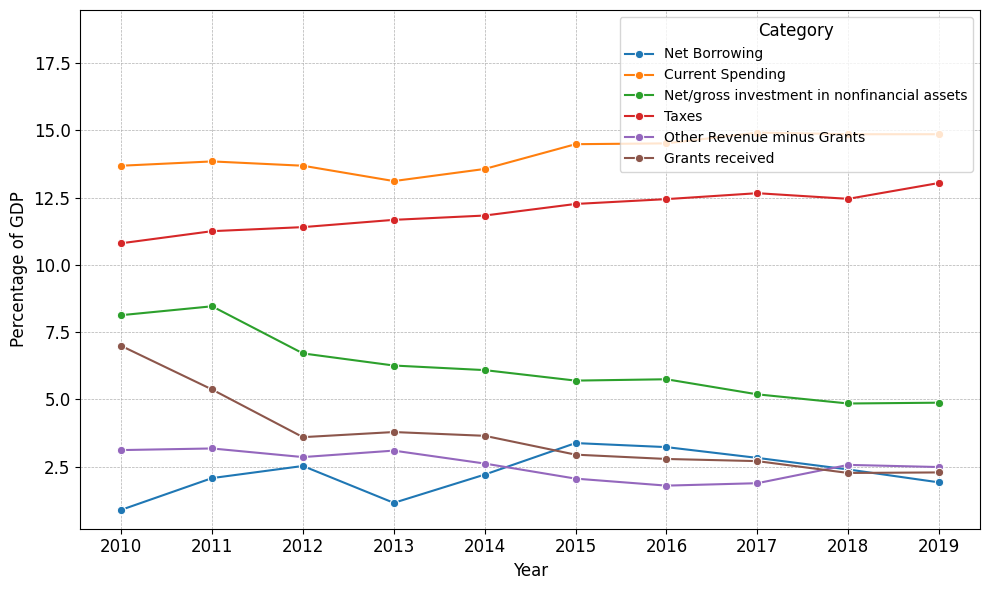

In [355]:
graph(['Net Borrowing', 'Current Spending', 'Net/gross investment in nonfinancial assets', 'Taxes', 'Other Revenue minus Grants', 'Grants received'])

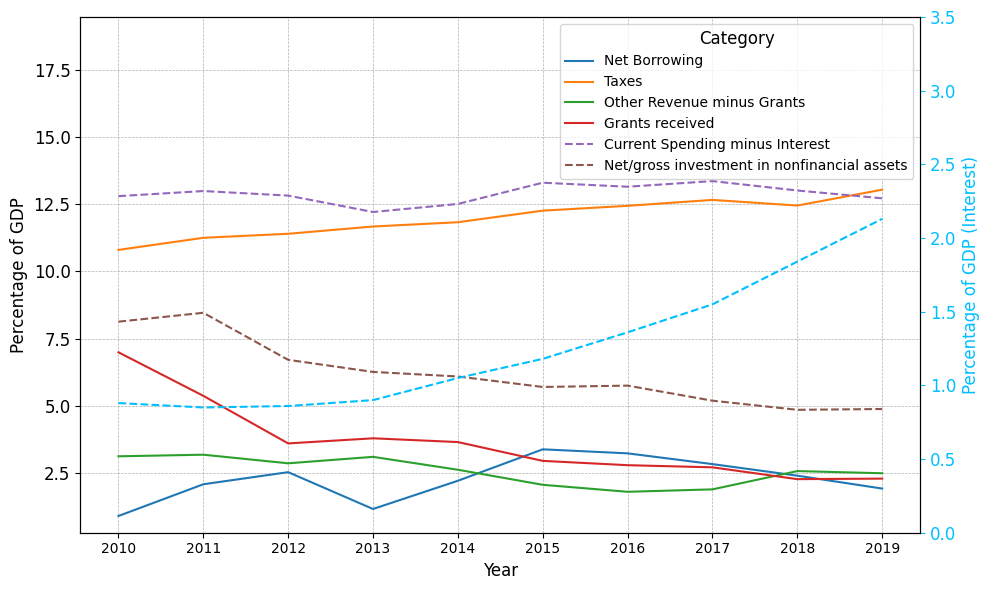

In [356]:
#net borrowing = - opposite of net lending
#current spending - net interest = expenses - net interest
#capital spending
#tax revenue
#non-tax revenue = revenue - tax
#interest

# rows_to_plot =  ["Net Borrowing", "Current Spending minus Interest", "Net/gross investment in nonfinancial assets", "Taxes", "Other Revenue", "Interest"]
# # Plotting
# plt.figure(figsize=(10, 6))
# for row in rows_to_plot:
#   sns.lineplot(x=rounded_by_year_average_df.columns, y=rounded_by_year_average_df.loc[row], marker='o', label=row)

#     # Add labels and title
# plt.xlabel('Year', fontsize=12)
# plt.ylabel('Percentage of Expenditure', fontsize=12)
#     # plt.title('Percentage of Tax Revenue Over Time')

#     # Customize the legend
# plt.legend(title='Category', title_fontsize='12', fontsize='10', loc='upper right')

#     # Customize the ticks and grid
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# plt.grid(True, linestyle='--', linewidth=0.5)

#     # Adjust y-axis limits to be 120% of the original range
# y_min, y_max = plt.ylim()
# y_range = y_max - y_min
# plt.ylim(y_min, y_max + 0.25 * y_range)

#     # Show the plot
# plt.tight_layout()
# plt.show()



# Define rows to plot
rows_to_plot = [
    "Net Borrowing", 
    "Current Spending minus Interest", 
    "Net/gross investment in nonfinancial assets", 
    "Taxes", 
    "Other Revenue minus Grants", 
    "Grants received"
    "Interest"
]

# Define markers
marker_style_1 = '-'  # Circle marker
marker_style_2 = '--'  # Square marker

# Define which rows get which marker
rows_with_marker_1 = ["Net Borrowing", "Taxes", "Other Revenue minus Grants", "Grants received"]
rows_with_marker_2 = [
    "Current Spending minus Interest", 
    "Net/gross investment in nonfinancial assets"
]


#new
# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the first set of rows
for row in rows_with_marker_1 + rows_with_marker_2:
    if row in rows_with_marker_1:
        linestyle = marker_style_1
    else:
        linestyle = marker_style_2
    sns.lineplot(ax=ax1, x=rounded_by_year_average_df.columns, y=rounded_by_year_average_df.loc[row], linestyle=linestyle, label=row)

# Customize the first y-axis
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Percentage of GDP', fontsize=12)
ax1.tick_params(axis='y', labelsize=12)
ax1.grid(True, linestyle='--', linewidth=0.5)

# Create a second y-axis for "Interest"
ax2 = ax1.twinx()
sns.lineplot(ax=ax2, x=rounded_by_year_average_df.columns, y=rounded_by_year_average_df.loc["Interest"], linestyle='--', color='#00BFFF', label='_nolegend_')

# Customize the second y-axis
ax2.set_ylabel('Percentage of GDP (Interest)', fontsize=12, color='#00BFFF')
ax2.tick_params(axis='y', labelsize=12, colors='#00BFFF')

# Combine legends from both y-axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, title='Category', title_fontsize='12', fontsize='10', loc='upper right')

# lines, labels = ax1.get_legend_handles_labels()
# ax1.legend(lines, labels, title='Category', title_fontsize='12', fontsize='10', loc='upper right')
# lines, labels = ax1.get_legend_handles_labels()
# ax1.legend(lines, labels, title='Category', title_fontsize='12', fontsize='10', loc='upper right')


# Adjust y-axis limits to be 120% of the original range
y_min, y_max = ax1.get_ylim()
y_range = y_max - y_min
ax1.set_ylim(y_min, y_max + 0.4 * y_range)
ax2.set_ylim(0, 3.5)

# Show the plot
plt.tight_layout()
plt.show()